In [ ]:
# Install required libraries
!pip install timm
!pip install torch torchvision


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import StepLR

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
from tqdm import tqdm

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Dataset path
dataset_path = "/content/drive/MyDrive/images"

# Transformations for grayscale images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure images are single-channel grayscale
    transforms.Resize((224, 224)),  # Resize images to 224x224 for Swin Transformer
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalization for grayscale images (mean and std for 1 channel)
])

# Load dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print class names
class_names = full_dataset.classes
print("Classes:", class_names)


Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
# Load a pre-trained Swin Transformer model and modify for 4-class classification
import timm
import torch.nn as nn
import torch

# Load a pre-trained Swin Transformer model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

# Modify the input layer to accept grayscale (1-channel) images
# Replace 3 input channels with 1, keeping other parameters the same
model.patch_embed.proj = nn.Conv2d(
    in_channels=1,  # Change to 1 for grayscale images
    out_channels=model.patch_embed.proj.out_channels,  # Keep the output channels the same
    kernel_size=model.patch_embed.proj.kernel_size,
    stride=model.patch_embed.proj.stride,
    padding=model.patch_embed.proj.padding
)

# Adjust the output layer for the number of classes
num_classes = len(class_names)  # Number of classes in your dataset
model.head = nn.Linear(model.head.in_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Training function
# Training function with adaptive output reshaping
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for inputs, labels in tqdm(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Check if output shape is 4D (batch, num_classes, height, width) and adapt it
        if outputs.dim() == 4:
            outputs = outputs.mean([2, 3])  # Global average pooling to flatten spatial dimensions

        # Ensure output is now [batch_size, num_classes]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        # Store predictions and labels for metrics calculation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, epoch_acc, precision, recall, f1




# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # Adaptive output reshaping if necessary
            if outputs.dim() == 4:
                outputs = outputs.mean([2, 3])  # Flatten spatial dimensions

            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Store predictions and labels for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, epoch_acc,precision, recall, f1
# Tracking metrics for visualization
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_precisions, train_recalls, train_f1s = [], [], []
val_precisions, val_recalls, val_f1s = [], [], []

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc,train_precision, train_recall, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion)

    scheduler.step()  # Update the learning rate

    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc*100:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1:.2f}\n")
    # Store metrics for visualization
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

Epoch 1/10


100%|██████████| 312/312 [59:34<00:00, 11.46s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 78/78 [16:45<00:00, 12.89s/it]


Training Loss: 0.4327, Accuracy: 8422.06%, Precision: 0.84, Recall: 0.84, F1 Score: 0.84
Validation Loss: 0.0721, Accuracy: 9759.04%, Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch 2/10


100%|██████████| 78/78 [00:30<00:00,  2.56it/s]


Training Loss: 0.0480, Accuracy: 9839.29%, Precision: 0.98, Recall: 0.98, F1 Score: 0.98
Validation Loss: 0.0157, Accuracy: 9955.82%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 3/10


100%|██████████| 78/78 [00:30<00:00,  2.58it/s]


Training Loss: 0.0219, Accuracy: 9932.70%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99
Validation Loss: 0.0557, Accuracy: 9779.12%, Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch 4/10


100%|██████████| 78/78 [00:29<00:00,  2.62it/s]


Training Loss: 0.0073, Accuracy: 9980.92%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0012, Accuracy: 9995.98%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 5/10


100%|██████████| 78/78 [00:30<00:00,  2.60it/s]


Training Loss: 0.0009, Accuracy: 9999.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0004, Accuracy: 10000.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 6/10


100%|██████████| 78/78 [00:29<00:00,  2.62it/s]


Training Loss: 0.0009, Accuracy: 9996.99%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0002, Accuracy: 10000.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 7/10


100%|██████████| 78/78 [00:30<00:00,  2.55it/s]


Training Loss: 0.0010, Accuracy: 9995.98%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0043, Accuracy: 9979.92%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 8/10


100%|██████████| 78/78 [00:29<00:00,  2.64it/s]


Training Loss: 0.0019, Accuracy: 9995.98%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0001, Accuracy: 10000.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 9/10


100%|██████████| 78/78 [00:29<00:00,  2.63it/s]


Training Loss: 0.0006, Accuracy: 9999.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0000, Accuracy: 10000.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 10/10


100%|██████████| 78/78 [00:29<00:00,  2.63it/s]

Training Loss: 0.0002, Accuracy: 10000.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0000, Accuracy: 10000.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00



Epoch 1/10
100%|██████████| 312/312 [59:34<00:00, 11.46s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 78/78 [16:45<00:00, 12.89s/it]
Training Loss: 0.4327, Accuracy: 84.22%, Precision: 0.84, Recall: 0.84, F1 Score: 0.84
Validation Loss: 0.0721, Accuracy: 97.59%, Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch 2/10
100%|██████████| 312/312 [05:25<00:00,  1.04s/it]
100%|██████████| 78/78 [00:30<00:00,  2.56it/s]
Training Loss: 0.0480, Accuracy: 98.39%, Precision: 0.98, Recall: 0.98, F1 Score: 0.98
Validation Loss: 0.0157, Accuracy: 99.55%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 3/10
100%|██████████| 312/312 [05:27<00:00,  1.05s/it]
100%|██████████| 78/78 [00:30<00:00,  2.58it/s]
Training Loss: 0.0219, Accuracy: 99.32%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99
Validation Loss: 0.0557, Accuracy: 97.79%, Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch 4/10
100%|██████████| 312/312 [05:27<00:00,  1.05s/it]
100%|██████████| 78/78 [00:29<00:00,  2.62it/s]
Training Loss: 0.0073, Accuracy: 99.80%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0012, Accuracy: 99.95%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 5/10
100%|██████████| 312/312 [05:27<00:00,  1.05s/it]
100%|██████████| 78/78 [00:30<00:00,  2.60it/s]
Training Loss: 0.0009, Accuracy: 99.99%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0004, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 6/10
100%|██████████| 312/312 [05:27<00:00,  1.05s/it]
100%|██████████| 78/78 [00:29<00:00,  2.62it/s]
Training Loss: 0.0009, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0002, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 7/10
100%|██████████| 312/312 [05:27<00:00,  1.05s/it]
100%|██████████| 78/78 [00:30<00:00,  2.55it/s]
Training Loss: 0.0010, Accuracy: 99.95%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0043, Accuracy: 99.79%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 8/10
100%|██████████| 312/312 [05:27<00:00,  1.05s/it]
100%|██████████| 78/78 [00:29<00:00,  2.64it/s]
Training Loss: 0.0019, Accuracy: 99.95%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0001, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 9/10
100%|██████████| 312/312 [05:28<00:00,  1.05s/it]
100%|██████████| 78/78 [00:29<00:00,  2.63it/s]
Training Loss: 0.0006, Accuracy: 99.99%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0000, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 10/10
100%|██████████| 312/312 [05:27<00:00,  1.05s/it]
100%|██████████| 78/78 [00:29<00:00,  2.63it/s]Training Loss: 0.0002, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0000, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

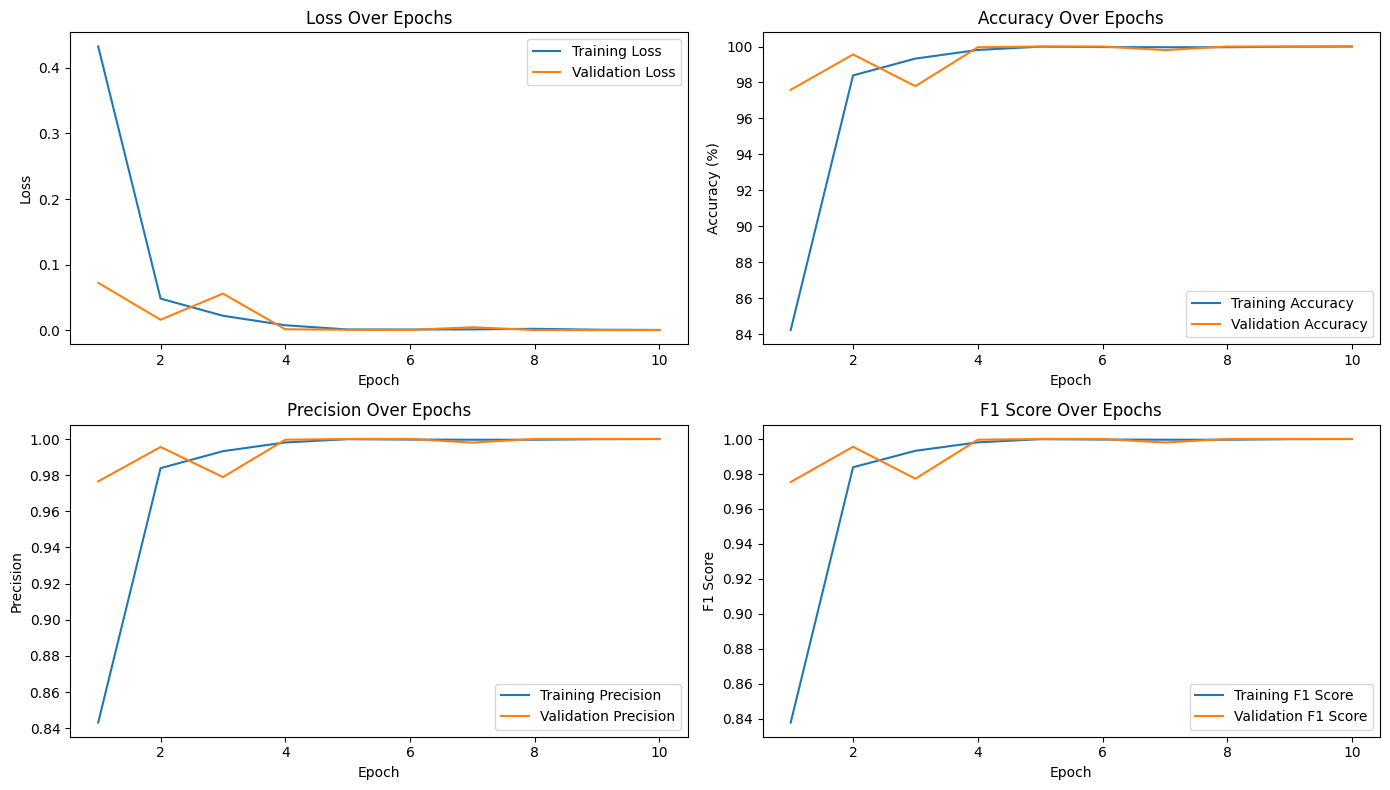

In [ ]:
epochs = np.arange(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Training Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Over Epochs')
plt.legend()

# Plot F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, label='Training F1 Score')
plt.plot(epochs, val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()